<font size="5">Variational Bayes - Regime Frequency</font>

Variational Bayes - Sampling the generative model

Using variational inference applied to time series data, the algorithm non-parametrically chooses M clusters each with distinct mean and covariance parameters allowing computation of a likelihood function for any time step. The model optimizes the parameters of the M clusters to maximize the likelihood of those parameters given the data. Similarity between probability distributions is measured via the KL-divergence:

𝐷𝐾𝐿(𝑃∥𝑄)=∑𝑖𝑃(𝑖)log𝑃(𝑖)𝑄(𝑖) 

In practice this works out to function as an unsupervised classification algorithm for the most likely distribution (mean and covariance) a time step comes from. This is applicable to discovering statistical market regimes in quantitative finance. This notebook is purely an exercise in scikit-learn's Bayesian optimization capabilities in this setting.

This variant of the notebook will sample from the posterior distribution over the parameters of the latent states, and their transition matrix that gives us a probability of switching to any given state based on the empirically observed data. This does not make a prediction, instead only describes the historical data and then re-samples it using the embedded Markov-switching procedure.

In [9]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

import sklearn 
import sklearn.mixture as mix 

I will be testing with a small asset universe of the 10Y Treasury ETF, a Commodity basket ETF, and Tech sector ETF. The goal will be time series clustering using variational inference. There are periods of time (regimes) where certain assets outperform the others and their precise relationship is captured by the latent states describing mean and covariance within a cluster. These latent states are the result of optimization by minimizing KL-divergence with a dirichlet process mixture model. 

Set num_components to a very high number so the data is fit in a non-parametric way where we need not know the number of clusters in advance. 

In [10]:
assetlist = [ 'IEF', 'GSG', 'IXN' ]
num_components = 99

Create the subset of assets.

In [11]:
m6 = pd.read_csv('./data/assets.csv')
m6_assets = pd.DataFrame()

for sym in assetlist: 
    m6_assets[sym] = m6[m6['symbol'] == sym]['price'].values

Formatting the training data. There is only training data and no test data in this exercise (it is a purely descriptive exercise). 1st-order differencing of the log price for each asset. 

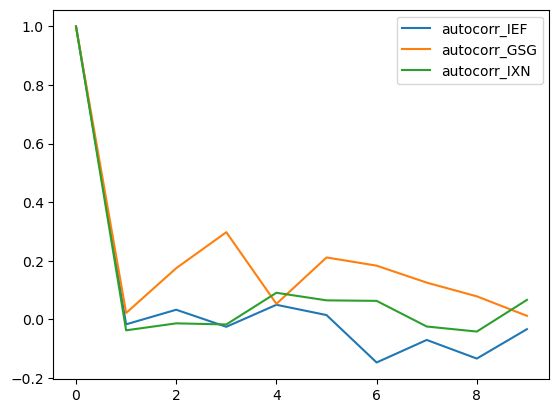

In [12]:
m6_subset = m6_assets.copy()
# First convert to log price 
m6_subset = m6_subset.apply(np.log)
# Then apply final 1st-order differencing to get a rate-of-change
m6_subset = m6_subset.apply(np.diff).dropna().reset_index().drop(columns='index')

# View Auto Correlation
autocorr_df = pd.DataFrame()
autocorr_df['decay_IEF'] = m6_subset['IEF'].apply(abs)
autocorr_df['decay_GSG'] = m6_subset['GSG'].apply(abs) 
autocorr_df['decay_IXN'] = m6_subset['IXN'].apply(abs) 
decay_func = lambda S, _range: [S.autocorr(lag=Lag) for Lag in _range]

sns.lineplot(data=decay_func(autocorr_df['decay_IEF'], range(0, 10)), label='autocorr_IEF') 
sns.lineplot(data=decay_func(autocorr_df['decay_GSG'], range(0, 10)), label='autocorr_GSG')
sns.lineplot(data=decay_func(autocorr_df['decay_IXN'], range(0, 10)), label='autocorr_IXN')
plt.show()

Instantiate a non-parametric clustering model using the dirichlet process and view the clustering results on the training data. The shaded regions on the plot represent the most frequently occuring latent state discovered using np.argmax(). 

In [13]:
dpgmm_model = mix.BayesianGaussianMixture(n_components=num_components, weight_concentration_prior_type='dirichlet_process')

In [14]:
dpgmm_model.fit(m6_subset)
states = dpgmm_model.predict(m6_subset)

state_counts = np.zeros(num_components)
for M in states:
  state_counts[M] += 1 

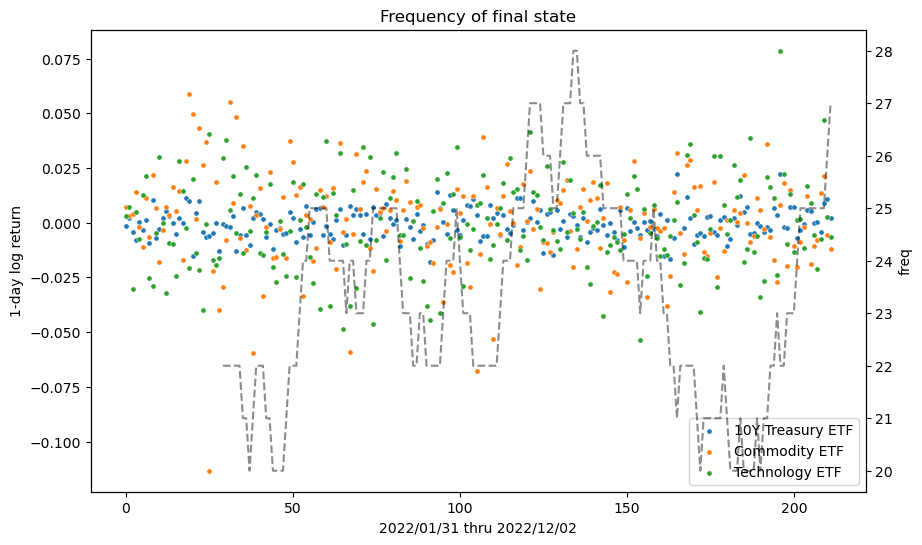

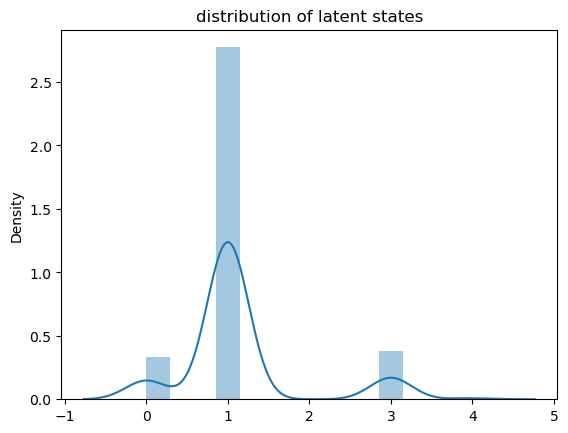

In [18]:
fig,ax = plt.subplots(figsize=(10, 6
                              ))
sns.scatterplot(data=m6_subset['IEF'], ax=ax, label='10Y Treasury ETF', s=14)
sns.scatterplot(data=m6_subset['GSG'], ax=ax, label='Commodity ETF', s=14)
sns.scatterplot(data=m6_subset['IXN'], ax=ax, label='Technology ETF', s=14)
ax2=ax.twinx()

freq_count = lambda St: np.sum([1 if M == states[-1] else 0 for M in St ])
freq_df = pd.DataFrame()
freq_df['freq'] = states
freq_df['freq'] = freq_df['freq'].rolling(30).apply(freq_count)
sns.lineplot(freq_df['freq'], linestyle='--', ax=ax2, color='black', alpha=0.45)

ax.set_title('Frequency of final state')
ax.set_ylabel('1-day log return')
ax.set_xlabel(f'2022/01/31 thru 2022/12/02')
plt.show()

ax2 = sns.distplot(states)
ax2.set_title('distribution of latent states')
plt.show()

In [19]:
print(dpgmm_model.means_[ states[-1] ])

[-5.54563124e-05 -7.63814852e-04  2.82383205e-03]
